In [1]:
import numpy as np
from math import tan, pi
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from matplotlib import cm 

In [2]:
# load tomography and iasp model
Pwave = np.loadtxt("berk_model_2015.txt")
iasp  = np.loadtxt("IASP.txt");
adiabat = np.loadtxt('adiabat_ceus.txt') # adiabatic temp
T_ref = np.loadtxt('reference_temp.txt')
d = ( Pwave[:,2] <= 660.) & ( Pwave[:,2] > 40. ) # last depth used in the current model
bffer    = Pwave[:,2] == 60 # to fill the model to top
longitde = Pwave[d,1]
latitude = Pwave[d,0]
depth    = Pwave[d,2]
delta_vp = Pwave[d,3]
delta_vp[np.where(delta_vp >= 5)] = 5 # at deeper depths
delta_vp[np.where(delta_vp <= -5)] = -5

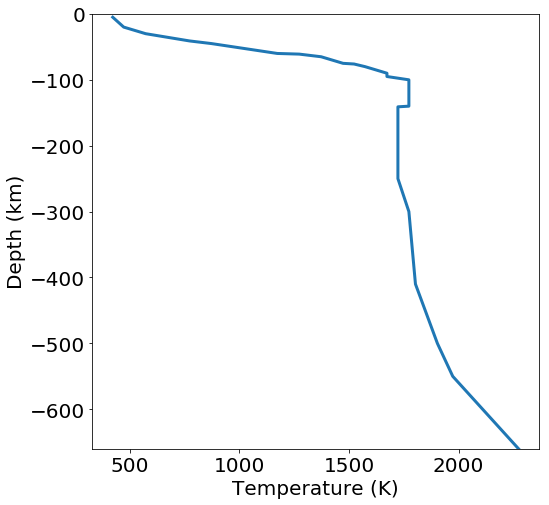

In [16]:
(fig, (ax1)) = plt.subplots(1, 1, figsize=(8,8))
plt.rcParams.update({'font.size': 20})
ax1.plot(T_ref[:,1] + 273, -T_ref[:,0], linewidth='3')
ax1.set_ylim([-660, 0])
ax1.set_xlabel('Temperature (K)')
ax1.set_ylabel('Depth (km)')
plt.savefig('reference_temperature.svg')

In [14]:
# root well defined
delta_vp[ (depth >=140) & (delta_vp >= 2) & (longitde >= -90.5) & (longitde < -84) & \
        (latitude > 33.) & (latitude < 37.)] = 0.

In [7]:
print (np.unique(depth))

[ 60.  95. 130. 165. 200. 240. 280. 320. 365. 410.]


In [3]:
# interpolate the tomography on a grid
npts   = 150
lat_q  = np.linspace(min(latitude), max(latitude), npts)
long_q = np.linspace(min(longitde), max(longitde), npts)
d_q    = np.unique(depth)
(grid_y, grid_x) = np.meshgrid(lat_q, long_q)
pnts   = np.column_stack((Pwave[bffer, 0], Pwave[bffer, 1])) # everything tested on small data-set

grid_vp = dT_p = np.ones((len(d_q), npts, npts))

for j in range(len(d_q)):
    grid_vp[j, :, :]   = griddata(pnts, delta_vp[19043*j:19043 + 19043*j], \
                               (grid_y, grid_x), method='nearest')
    
longitde = np.reshape(np.tile(grid_x, (len(d_q),1)), (npts*npts*len(d_q)))
latitude = np.reshape(np.tile(grid_y, (len(d_q),1)), (npts*npts*len(d_q)))
depth    = np.reshape(np.repeat(d_q, npts*npts), (npts*npts*len(d_q)))
delta_vp = np.reshape(grid_vp,(npts*npts*len(d_q)))

In [4]:
# define mineral physics constants used in this study
data = np.array([('ol', 0.83, 4.2, 1.4, -0.017e9, -0.014e9, 129e9, 81e9, 3222, 0.201e-4, 0.139e-7, 0.1627e-2, 
                  1.658e2, 0.2332e-2, -0.3971e7) , 
       ('opx', 0.15, 7, 1.6, -0.027e9, -0.012e9, 109e9, 75e9, 3215, 0.3871e-4, 0.0446e-7, 0.03435e-2, 
       1.855e2, 0.233e-2, -0.6326e7) , 
       ('gt', 0.02, 4.4, 1.4, -0.019e9, -0.01e9, 171e9, 92e9, 3565, 0.0991e-4, 0.1165e-7, 1.0624e-2, 
       1.44e2, 0.188e-2, -0.135e7)], 
        dtype=[('name', 'U10'), ('conc', 'f4'), ('KPDer', 'f4'), ('MuPDer', 'f4'), 
        ('KTDer', 'f4'), ('MuTDer', 'f4'), ('K', 'f4'), ('Mu', 'f4'), ('rho', 'f4'), 
        ('a0', 'f4'), ('a1', 'f4'), ('a2', 'f4'), ('cp0', 'f4'), ('cp1', 'f4'), ('cp2', 'f4')])
A = 1.48e-1 ; H = 500e3; V = 20e-6; a = 0.15
R = 8.314

In [5]:
def density(a0, a1, a2, rho0, Ta):
    T0=300.
    return rho0 * np.exp(a0*(Ta - T0) + 0.5*a1*(Ta**2 - T0**2) + a2*(np.log(Ta) - np.log(T0)))

In [6]:
def derivative (f, x, h, P, K, Kdash):
    return (f(x+h, P, K, Kdash) - f(x-h, P, K, Kdash)) / (2.0*h) # might want to return a small non-zero if ==0

def epsilon(x, P, K, Kdash):
    return  ( (1 - 2*x) ** (5/2) ) * (3 * K * x + ( ( 9 * K * (4 - Kdash) )/ 2 ) * (x ** 2) )  + P 

def solve_ep (f, x0, h, P, K, Kdash):
    lastX = x0
    nextX = lastX + 10 * h  # "different than lastX so loop starts OK
    #print(abs(lastX - nextX)) 
    while (abs(lastX - nextX) > h):  # this is how you terminate the loop - note use of abs()
        newY  = epsilon(nextX,  P, K, Kdash)                     # just for debug... see what happens
#         print (newY)     # print out progress... again just debug
        lastX = nextX
        nextX = lastX - newY / derivative(f, lastX, h, P, K, Kdash)  # update estimate using N-R
    return nextX

In [7]:
x0 = 1.e-8
pressures = adiabat[:,0]
depth_a =  adiabat[:,1] / 1e3 # tomography is in m, easier for comparison
T_a = adiabat[:,2] + 273
strain = np.ones(len(pressures))
rho = np.ones(len(pressures))

# compositional dependence 
rho_avg = data['rho'][0] * data['conc'][0] + data['rho'][1] * data['conc'][1] + \
            data['conc'][2] * data['rho'][2]
K_avg = ( data['conc'][0] * data['K'][0] + data['conc'][1] * data['K'][1] + data['conc'][2]*data['K'][2])
Muavg = ( data['conc'][0] * data['Mu'][0] + data['conc'][1] * data['Mu'][1] + data['conc'][2]*data['Mu'][2])
KPDer_avg = ( data['conc'][0] * data['KPDer'][0] + data['conc'][1] * data['KPDer'][1] + \
          data['conc'][2]*data['KPDer'][2])

for i in range (len(pressures)):
    Ta   = (T_a [ depth_a <= depth[i]].max()) # reference temperature with depth
    strain[i]     = solve_ep (epsilon, x0, 1.e-15, pressures[i], K_avg, KPDer_avg) # equation to get x
#     rho[i] = ( data['conc'][0] *  data['rho'][0] + data['conc'][1] * data['rho'][1] + \
#               data['conc'][2] * data['rho'][2] ) * ( ( 1 - ( 2 * strain[i] ) ) ** (3/2) )
    rho[i] = (( data['conc'][0] *  density ( data['a0'][0], data['a1'][0], data['a2'][0], data['rho'][0], Ta) ) 
    + ( data['conc'][1] *  density ( data['a0'][1], data['a1'][1], data['a2'][1], data['rho'][1], Ta) )
    + ( data['conc'][2] *  density ( data['a0'][2], data['a1'][2], data['a2'][2], data['rho'][2], Ta) ) ) \
    * ( ( 1 - ( 2 * strain[i] ) ) ** (3/2) )

In [28]:
# calculation of error due to single potential temperature
Ta = 1800+273
rho = (( data['conc'][0] *  density ( data['a0'][0], data['a1'][0], data['a2'][0], data['rho'][0], Ta) ) 
    + ( data['conc'][1] *  density ( data['a0'][1], data['a1'][1], data['a2'][1], data['rho'][1], Ta) )
    + ( data['conc'][2] *  density ( data['a0'][2], data['a1'][2], data['a2'][2], data['rho'][2], Ta) ) )
rho

delK_T = ( data['conc'][0] * data['KTDer'][0] + data['conc'][1] * data['KTDer'][1] +\
         data['conc'][2]*data['KTDer'][2] )*(400)
delmu_T = ( data['conc'][0] * data['MuTDer'][0] + data['conc'][1] * data['MuTDer'][1] +\
         data['conc'][2]*data['MuTDer'][2] )*(400)

delK_T, delmu_T, K_avg, Muavg, rho

(-7416000000.0,
 -5448000000.0,
 126840000000.0,
 80319996000.0,
 3460.134160109961)

In [10]:
# # corrections to the moduli
# def moduli ( To, data, x, comp):
#     return  ( data['KTDer'][comp] * (x - To) + (4/3) * data['MuTDer'][comp] * (x - To) )
        
# def moduli_der (To, data, x, comp):
#     return data['KPDer'][comp] * np.exp ( data['a0'][comp] * (x - To) + data['a1'][comp] * (x - To) ** 2 \
#             + data['a2'][comp] * np.log ( abs(x - To)) ) * ( data['a0'][comp] + data['a1'][comp] * (x - To) \
#             + data['a2'][comp] /(x - To) )  +  (4/3) * data['MuPDer'][comp] * np.exp ( data['a0'][comp] \
#             * (x - To) + data['a1'][comp] * (x - To) ** 2 + data['a2'][comp] * np.log (abs(x - To ) ) )* \
#             ( data['a0'][comp] + data['a1'][comp] * (x - To) + data['a2'][comp] /(x - To) ) 

# # function for K and mu
# def p_modulus ( To, data, x, comp , ep ):   
#     return ( ( 1 - 2*ep )**(5/2) ) * ( moduli ( To, data, x, comp)   + \
#             ep * ( 5 * moduli ( To, data, x, comp)  - 3 * ( data['KTDer'][comp] ) * (x -To) * \
#                   ( data['KPDer'][comp]  + (4/3) * data['MuPDer'][comp] ) - 3 * data['K'][comp] * \
#                   ( moduli_der (To, data, x, comp ) ) ) )  

# def density_der(comp, rho, To, data, x):
#     return ( - rho * np.exp (- data['a0'][comp] * (x - To) - data['a1'][comp] * (x - To) ** 2 \
#             - data['a2'][comp] * np.log (abs (x - To)) ) * ( data['a0'][comp] + data['a1'][comp] * (x - To) \
#             + data['a2'][comp] /(x - To) ) )

In [13]:
# corrections to the moduli
def moduli ( To, data, x, comp):
    return  ( data['KTDer'][comp] * (x - To) + (4./3) * data['MuTDer'][comp] * (x - To) )
        
def moduli_der (To, data, x, comp):
    return ( data['KPDer'][comp] + (4/3) * data['MuPDer'][comp] ) * \
           ( ( np.exp ( data['a0'][comp] * (x - 300) + ( data['a1'][comp] / 2 ) * (x - 300) ** 2 \
             ) ) * ( data['a0'][comp] + data['a1'][comp] * (x) )  * ( x - To ) ) 

# function for K and mu
def p_modulus ( To, data, x, comp , ep ):   
    return ( ( 1 - 2*ep )**(5/2) ) * ( moduli ( To, data, x, comp)   +             ep * ( 5 * moduli ( To, data, x, comp)  - 3 * ( data['KTDer'][comp] ) *            ( x- To ) * ( data['KPDer'][comp]  + (4/3) * data['MuPDer'][comp] ) - 3 * data['K'][comp] *                   ( moduli_der (To, data, x, comp ) ) ) )  

def density_der(comp, rho, To, data, x, ep):
    return - data['rho'][comp] * np.exp (- data['a0'][comp] * (x - 1300) - ( data['a1'][comp] / 2) * (x**2 - 1300**2)) * ( data['a0'][comp] + data['a1'][comp] * x ) * ( x - To) * ( 1 - 2*ep )**(3/2.) 


In [14]:
# inversion for temperature
def double_derivative (f, x, h, delVp, ep, rho, To, data, P, Vso, Vpo):
    return (f(x+h, delVp, ep, rho, To, data, P, Vso, Vpo) + f(x-h, delVp, ep, rho, To, data, P, Vso, Vpo) - \
            2 * f(x-h, delVp, ep, rho, To, data, P, Vso, Vpo) ) / (h**2)  

def derivative (f, x, h, delVp, ep, rho, To, data, P, Vso, Vpo):
    return (f(x+h, delVp, ep, rho, To, data, P, Vso, Vpo) - f(x-h, delVp, ep, rho, To, data, P, Vso, Vpo)  ) / (2 * h)

def temperature ( x, delVp, ep, rho, To, data, P, Vso, Vpo):
    p_modulus0 = K_avg + (4/3)*Muavg     
    return ( 1/(2 * np.sqrt(rho_avg * p_modulus0) ) ) * ( data['conc'][0] *  p_modulus ( To, data, x, 0 , ep ) +
            data['conc'][1] *  p_modulus ( To, data, x, 1 , ep ) + data['conc'][2] *
            p_modulus ( To, data, x, 2 , ep ) ) - ( ( np.sqrt(p_modulus0)/( 2 * ( (rho_avg) ** 3/2 ) ) ) * \
            ( data['conc'][0] * density_der (0, rho, To, data, x , ep) +  data['conc'][1] * 
             density_der (1, rho, To, data, x, ep) + data['conc'][2] * density_der (2, rho, To, data, x, ep ) ) ) \
             + ( ( a * H * (4/3) * (Vso/Vpo)**2 ) * ( ( A * ( ( 2*np.pi )**a ) * 
             np.exp ( a * ( H + P*V ) / ( R * x ) ) ) ** -1 ) /(2 * R * ( To ** 2) * np.tan ( np.pi * a/2 ) ) ) \
             * (x - To) - delVp


def solve_T (f, x0, h, delVp, ep, rho, To, data, P, Vso, Vpo):
    lastX = x0
    nextX = lastX +  10 * h  # "different than lastX so loop starts OK
    while (abs(lastX - nextX) > h):  # this is how you terminate the loop - note use of abs()        
        newY  = temperature (nextX, delVp, ep, rho, To, data, P, Vso, Vpo)          # just for debug... see what happens
#         print (newY)     # print out progress... again just debug
        lastX = nextX
        nextX = lastX -  temperature (nextX,  delVp, ep, rho, To, data, P, Vso, Vpo)  /  \
                double_derivative(f, lastX, h,  delVp, ep, rho, To, data, P, Vso, Vpo)  # update estimate using N-R
    return nextX

In [32]:
To = 1173
x = 600
Vso = 4500
Vpo = 8200
comp = 0
P = 3e9
ep = strain[8]
print(p_modulus ( To, data, x, 2 , ep ))
p_modulus0 = K_avg + (4/3)*Muavg   
( 1/(2 * np.sqrt(rho_avg * p_modulus0) ) ) * ( data['conc'][0] *  p_modulus ( To, data, x, 0 , ep ) +
            data['conc'][1] *  p_modulus ( To, data, x, 1 , ep ) + data['conc'][2] *
            p_modulus ( To, data, x, 2 , ep ) ) - ( ( np.sqrt(p_modulus0)/( 2 * ( (rho_avg) ** 3/2 ) ) ) * \
            ( - rho * np.exp (- data['a0'][comp] * (x - To) - data['a1'][comp] * (x - To) ** 2  ) * \
             ( data['a0'][comp] + data['a1'][comp] * (x - To) \
            + data['a2'][comp] /(x - To) ) ) ) +  ( ( a * H * (4/3) * (Vso/Vpo)**2 ) * ( ( A * ( ( 2*np.pi )**a ) * 
             np.exp ( a * ( H + P*V ) / ( R * x ) ) ) ** -1 ) /(2 * R * ( To ** 2) * np.tan ( np.pi * a/2 ) ) ) \
             * ( x - To) 

20117479520.71467


array([411.18476022, 411.18476022, 411.18476022, 411.18476022,
       411.18476022, 411.18476022, 411.18476022, 411.18476022,
       411.18476022, 411.18476022, 411.18476023, 411.18476023,
       411.18476023, 411.18476023, 411.18476023, 411.18476023,
       411.18476023, 411.18476023, 411.18476023, 411.18476023,
       411.18476023, 411.18476024, 411.18476024, 411.18476024,
       411.18476024, 411.18476024, 411.18476024, 411.18476024,
       411.18476024, 411.18476024, 411.18476024, 411.18476024,
       411.18476024, 411.18476025, 411.18476025, 411.18476025,
       411.18476025, 411.18476025, 411.18476025, 411.18476025])

In [17]:
Vp_o = np.ones(len(depth)) ; Vs_o = np.ones(len(depth))
dVp = np.ones(len(depth)) ; Vp = np.ones(len(depth))
To = np.ones(len(depth)) ; ep_cal = np.ones(len(depth))
rho_cal = np.ones(len(depth)); T = np.ones(len(depth)) 
P = np.ones(len(depth)) 

In [23]:
# invert for temperatures
x0 = 500;
depth_a =  adiabat[:,1] / 1e3 # tomography is in m, easier for comparison
# T_a = adiabat[:,2]

for i in range (len(depth)):
    data['a2'][:] = 0; # ignore second terms
    Vp_o[i]  = (iasp[:,1][iasp[:,0] <= depth[i]].max())*1.e3 # find P wave reference velocity for the tomography
    Vs_o[i]  = (iasp[:,2][iasp[:,0] <= depth[i]].max())*1.e3 # find S wave reference velocity for the tomography
    To[i]   = (T_ref[:,1][T_ref[:,0] <= depth[i]].max()) + 273# reference temperature with depth
    dVp[i]   = delta_vp[i] * Vp_o[i]/100; 
    Vp[i]    = dVp[i] + Vp_o[i]
    ep_cal[i]  = strain [depth_a <= depth[i]].max()
    P[i]     = (pressures[depth_a <= depth[i]].max())
    rho_cal[i] = rho [depth_a <= depth[i]].max()
#     equation to get x
    T[i]     = solve_T (temperature, x0, 1,  dVp[i], ep_cal[i], rho_cal[i], To[i], data, P[i], 
                         Vs_o[i], Vp_o[i])


In [49]:
np.savetxt('T_inv.txt', T)

In [10]:
T_d = np.loadtxt('T_inv_deep.txt')
T = np.loadtxt('T_inv.txt')
T_results = np.concatenate((T, T_d))
# T_homog = T_results[depth<200]
# T_homog_200 = np.concatenate((T_homog, To[depth>=200]))

# print (len(T_homog_200))

(array([[   5.,  150.],
        [  20.,  200.],
        [  25.,  250.],
        [  30.,  300.],
        [  41.,  500.],
        [  45.,  600.],
        [  50.,  700.],
        [  60.,  900.],
        [  61., 1000.],
        [  65., 1100.],
        [  75., 1200.],
        [  76., 1250.],
        [  80., 1300.],
        [  90., 1400.],
        [  95., 1400.],
        [ 100., 1500.],
        [ 110., 1500.],
        [ 120., 1500.],
        [ 140., 1500.],
        [ 141., 1450.],
        [ 150., 1450.],
        [ 160., 1450.],
        [ 250., 1450.],
        [ 300., 1500.],
        [ 410., 1530.],
        [ 500., 1630.],
        [ 550., 1700.],
        [ 660., 2000.]]),
 array([1173., 1173., 1173., ..., 1973., 1973., 1973.]))

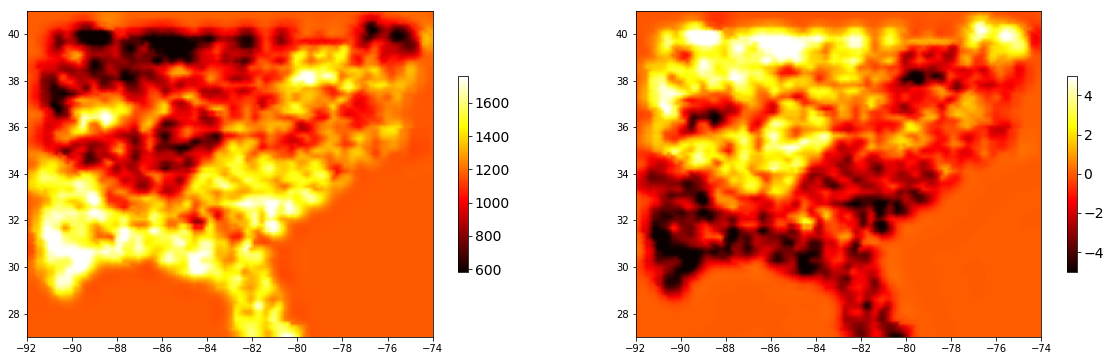

-95.660486


In [12]:
d_cal   = np.reshape(depth,(len(d_q), npts, npts))
T_cal   = np.reshape(T_results, (len(d_q), npts, npts))
dVp_cal = np.reshape(delta_vp, (len(d_q), npts, npts))
# Vp_cal = np.reshape(Vp, (len(d_q), npts, npts))
lat_cal = np.reshape(latitude,(len(d_q), npts, npts))
long_cal= np.reshape(longitde,(len(d_q), npts, npts))
n = 0
(fig, (ax1, ax2)) = plt.subplots(1, 2, figsize=(20,6))
plt.rcParams.update({'font.size': 14})
CB = ax1.pcolormesh(long_cal[n,:, :], lat_cal[n, :, :], T_cal[n ,:, :], cmap=cm.hot, shading='gouraud')
CB1 = ax2.pcolormesh(long_cal[n,:, :], lat_cal[n, :, :], dVp_cal[n ,:, :], cmap=cm.hot, shading='gouraud')
cbar = plt.colorbar(CB, shrink=0.6, ax=ax1)
cbar2 = plt.colorbar(CB1, shrink=0.6, ax=ax2)

CB.axes.set_xlim([-92, -74])
CB.axes.set_ylim([27, 41])
CB1.axes.set_xlim([-92, -74])
CB1.axes.set_ylim([27, 41])
plt.show()
print(np.unique(longitde)[n])

In [6]:
# addting a buffer layer
longitde_c = np.concatenate([np.reshape (np.tile(grid_x, (4,1)), (npts*npts*4)), longitde])
latitude_c   = np.concatenate([np.reshape (np.tile(grid_y, (4,1)), (npts*npts*4)), latitude])
depth_c    = np.concatenate([5*np.ones(npts*npts), 20*np.ones(npts*npts), \
                             30*np.ones(npts*npts), 40*np.ones(npts*npts), depth])
# T_c = np.concatenate([423*np.ones(npts*npts), 473*np.ones(npts*npts), \
#                       573*np.ones(npts*npts), 673*np.ones(npts*npts), T_results])
#T_homog_c = np.concatenate([423*np.ones(npts*npts), 473*np.ones(npts*npts), \##
#                       573*np.ones(npts*npts), 673*np.ones(npts*npts), T_homog_200])
#print (np.shape(latitude_c), np.shape(depth_c), np.shape(longitde_c), np.shape(T_c))

r = (6370 - depth_c)*1e3
longitude = (360 + longitde_c)*np.pi/180
latitde = (90 - latitude_c)*np.pi/180
ind = np.lexsort((r, longitude, latitde))
# np.savetxt('initial_temperature_no_root.txt', \
#             np.stack((r[ind], longitude[ind], latitde[ind], T_c[ind]), axis=-1))



# np.savetxt('initial_temperature_Pder_homog_200_new.txt', \
#             np.stack((r[ind], longitude[ind], latitde[ind], T_homog_c[ind]), axis=-1))

In [7]:
np.savetxt('delv.txt', delta_vp[ind])

IndexError: index 405149 is out of bounds for axis 1 with size 337500

In [26]:
ind = np.lexsort((latitude_c, longitde_c, depth_c))
np.savetxt('initial_temperature_lat_long_hm.txt', \
            np.stack((depth_c[ind], longitde_c[ind], latitude_c[ind], T_homog_c[ind]), axis=-1))

In [11]:
np.size(np.unique(depth_c))

19

NameError: name 'depth_c' is not defined